# Cross-correlation

We often encounter the need to match the pattern between two signals. For example, we may have recorded a whale call on two different hydrophones and want to identify the difference of signal arrival time. In other cases, we may want to find where the reflection of an object is in a long and noisy echo trace by finding the matching pattern of the transmit signal. A popular method to do these is to cross-correlate the target signal with the **template**, or **replica**. In the first example, the replica would be the whale call from one of the hydrophones; in the second example, the replica would be the transmit signal. This is also known as [**matched filter**](https://en.wikipedia.org/wiki/Matched_filter) in signal processing.

Below, we illustrate this by using two identical chirps that differ by a time delay.

In [5]:
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt

In [6]:
N = 1000
end_time = 1
freq = 50
time = np.linspace(0, end_time, end_time*N, endpoint=False)

In [7]:
def chirp_short_offset(offset):
   if offset>0.1 and offset<0.7:
       N = 1000
       time = np.linspace(0, end_time, N, endpoint=False) # 1 sec
       A = 1
       cw = A*np.sin(2*np.pi*freq*time) # zero phase
       left = np.zeros(int(offset*N))        
       middle_window = signal.windows.tukey(int(N/8), alpha=0.16)
       right = np.zeros(N-int(offset*N)-int(N/8))
       window = np.hstack((left, middle_window, right))
       cw_short =  cw * window
       return(cw_short)
   else:
       print("Offset out of range")

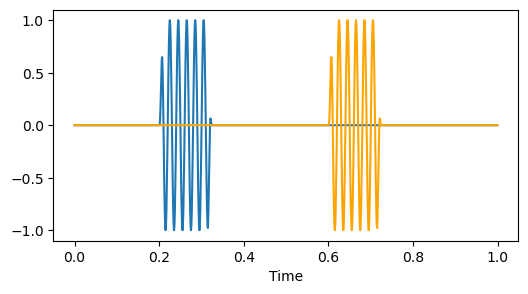

In [8]:
chirp1 = chirp_short_offset(offset=0.2)
chirp2 = chirp_short_offset(offset=0.6)

plt.figure(figsize=(6, 3))
plt.plot(time, chirp1)
plt.plot(time, chirp2, "orange")
plt.xlabel("Time")
plt.show()

## Pattern Alignment

The cross-correlation operation basically shifts the template in time and multiply with the corresponding segment in the other signal to calculate the correlation. The correlation between the two signals can be used as a measure of similarity between them. Therefore, we can use the time shift that produce the highest correlation to identify what the lag between the two signals are.

### Alignment Widget
We will demonstrate this idea with a widget the second signal backwards in time to match the first signal.

In [9]:
from ipywidgets import interact
import ipywidgets as widgets

In [23]:
def plot_shifted_chirp(time_shift):

    N = 1000
    end_time = 1
    time = np.linspace(0, end_time, end_time*N, endpoint=False)

    chirp1 = chirp_short_offset(offset=0.2)
    chirp2 = chirp_short_offset(offset=0.6+time_shift)

    plt.figure(figsize=(6, 3))
    plt.plot(time, chirp1)
    plt.plot(time, chirp2, "orange")
    plt.title("Signal Alignment")
    plt.xlabel("Time")
    plt.show()

out = interact(
    plot_shifted_chirp,
    time_shift=widgets.FloatSlider(
        value=-0.2,
        min=-0.49,
        max=0.0,
        step=-0.01,
        description='Time shift',
        continuous_update=True,
    )
)

interactive(children=(FloatSlider(value=-0.2, description='Time shift', max=0.0, min=-0.49, step=-0.01), Outpu…

### Cross-Correlation

The cross-correlation between two real continuous signals $f,g$ is defined as:

$$ R_{fg}(\tau) = \int_{-\infty}^{\infty} f(t) g(t+\tau) dt $$

where $\tau$ is the shift or lag, and the resulting function is a function of the lag. 

For discrete finite signals of lenght $M$ and $N$ this translates to:

$$R_{fg}[l] = \sum_{k=0}^{M-1}f[k]g[k+l]$$

where $k=-(M-1),...,0, ... (N-1)$.

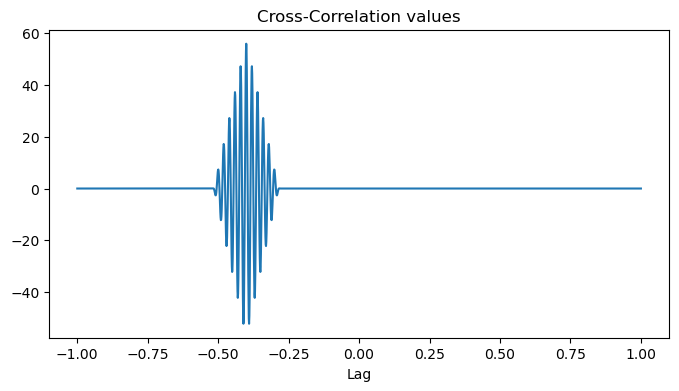

In [32]:
R = signal.correlate(chirp1, chirp2, mode="full")
lags = signal.correlation_lags(chirp1.size, chirp2.size, mode="full")

plt.figure(figsize=(8,4))
plt.plot(np.linspace(-1,1, len(lags)), R, '-')
plt.title("Cross-Correlation values")
plt.xlabel("Lag")
plt.show()

We see that the lag of maximum correlation is around -0.4 and we can extract it by evaluating its `argmax`.

In [31]:
lag = lags[np.argmax(R)]
print(np.linspace(0,-1, 1000)[np.abs(lag)])

-0.40040040040040037


:::{caution}
Note, by default the `correlate` function computes all possible shifts, thus the output is an array of size $M+N-1$. When a signal is shifted it is padded with zeros to compute the correlation. If one wants to limit to the range to non-padded values, one can use the `mode = 'valid'` option or to align to the first signal the `mode = 'same'` option.
:::

### Cross-Correlation Widget

In [12]:
def plot_crosscorrelation(time_shift):

    # define two signals
    chirp1 = chirp_short_offset(offset=0.2)
    chirp2 = chirp_short_offset(offset=0.6+time_shift)
    N = 1000
    end_time = 1
    time = np.linspace(0, end_time, end_time*N, endpoint=False)

    # plot both signals
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(time, chirp1)
    ax1.plot(time, chirp2, "orange")
    ax1.set_xlabel("Time")
    ax1.title.set_text("Signals")
    fig.tight_layout()


    # cross-correlation
    R = sp.signal.correlate(chirp1, chirp2)
    R = signal.correlate(chirp1, chirp_short_offset(offset=0.6), mode="full")
    lags = signal.correlation_lags(chirp1.size, chirp2.size, mode="full")

    # plot cross-correlation
    ax2.plot(np.linspace(-1,0,1000),R[:1000])
    plt.plot(time_shift, R[np.abs(1000 + int(time_shift*1000))], 'ro')
    ax2.set_xlabel("Time Offset")
    ax2.title.set_text("Cross-correlation")
    fig.tight_layout()
    


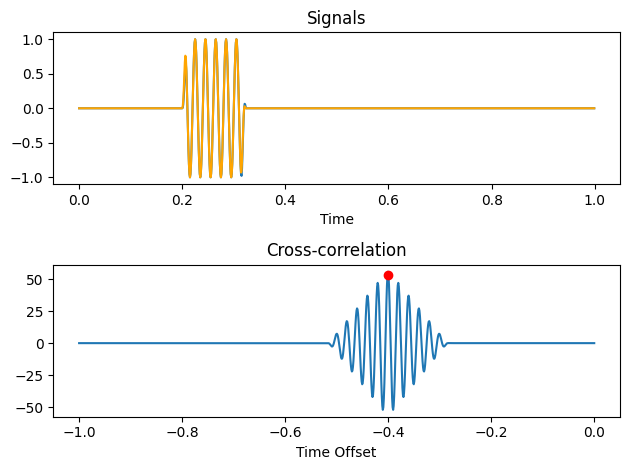

In [13]:
plot_crosscorrelation(-0.4)

In [14]:
time_shift_slider = widgets.FloatSlider(
    value=-0.4,
    min=-0.5,
    max=0,
    step=0.01,
    description='Time shift:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

out = interact(plot_crosscorrelation, time_shift=time_shift_slider)

interactive(children=(FloatSlider(value=-0.4, description='Time shift:', max=0.0, min=-0.5, readout_format='d'…

:::{note}
The approach of matching signals with cross-correlation is also called matched filtering.
:::